# K-means IPC classes
In this notebook we train a k-means classifier on the set of IPC classes documents contain. By doing this, we can assign documents "soft classes", the centroids from their k-means. This soft class can then be used to try to understand how documents of similar class affect each other in the semantic vector clusterings

In [15]:
import torch
import clip
from PIL import Image
import zipfile
from pathlib import Path
import json
import math
from collections import defaultdict
from torch.nn.functional import pad
#from transformers import AutoTokenizer, AutoModelForMaskedLM
from tqdm.notebook import tqdm
import pickle
import numpy as np

In [70]:
def get_patent_classes(packaged, taken_patents):
    with zipfile.ZipFile(packaged) as z:
        document_classes = dict()
        for info in tqdm(z.infolist()):
            patent, filename = info.filename.split('/')
            base, ext = filename.split('.')
            if ext == 'json':
                with z.open(info) as fp:
                    patent_info = json.load(fp)                    
                    patent_number = patent_info['document_number']
                    if patent_number in taken_patents:
                        continue
                    patent_classes = patent_info['ipc_classes']
                    document_classes[patent_number] = patent_classes
                    taken_patents.add(patent_number)
            
        return  document_classes

            
    

        

In [71]:
packaged = {0: Path('F:/datasets/PRV_KEMI_DATA/packaged_patents/english_netto_list.zip'),
            1: Path('F:/datasets/PRV_KEMI_DATA/packaged_patents/complement_english.zip'),
            2: Path('F:/datasets/PRV_KEMI_DATA/packaged_patents/english_random_sample.zip')}


In [72]:
taken_patents = set()
patent_classes = {label: get_patent_classes(p, taken_patents) for label, p in packaged.items()}


  0%|          | 0/208855 [00:00<?, ?it/s]

  0%|          | 0/185386 [00:00<?, ?it/s]

  0%|          | 0/176057 [00:00<?, ?it/s]

In [106]:
top_main_class_set = set()
top_num_set = set()
last_main_class_set = set()
sub_class_set_coarse = set()
sub_class_set_fine = set()

for label, label_patents in patent_classes.items():
    for patent_number, document_classes in label_patents.items():
        for main_class, sub_class in document_classes:
            top_main, *main_num, last_main = main_class
            top_main_class_set.add(top_main)
            top_num_set.add((top_main, *main_num))
            last_main_class_set.add((top_main, *main_num, last_main))

            sub_left, *_ = sub_class.split('/')
            sub_class_set_coarse.add((main_class, sub_left))
            sub_class_set_fine.add((main_class, sub_class))

In [109]:
len(top_main_class_set)

8

The main idea here is that we create embeddings from random vectors. These embedddings are the concatenation of one random vector unique to each prefix of the sub class

In [118]:
emb_dim = 16

np.random.seed(1729)

top_main_class_set_embedding = np.random.randn(len(top_main_class_set), emb_dim)
top_num_set_embedding = np.random.randn(len(top_num_set), emb_dim)
last_main_class_set_embedding = np.random.randn(len(last_main_class_set), emb_dim)
sub_class_set_coarse_embedding = np.random.randn(len(sub_class_set_coarse), emb_dim)
sub_class_set_fine_embedding = np.random.randn(len(sub_class_set_fine), emb_dim)

top_main_class_set_vocab = {c: i for i, c in enumerate(sorted(top_main_class_set))}
top_num_set_vocab = {c: i for i, c in enumerate(sorted(top_num_set))}
last_main_class_set_vocab = {c: i for i, c in enumerate(sorted(last_main_class_set))}
sub_class_set_coarse_vocab = {c: i for i, c in enumerate(sorted(sub_class_set_coarse))}
sub_class_set_fine_vocab = {c: i for i, c in enumerate(sorted(sub_class_set_fine))}


In [117]:
top_main_class_set_vocab

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7}

In [119]:
labeled_embeddings = dict()
labeled_documents = dict()
for label, label_patents in patent_classes.items():
    n_patents = len(label_patents)
    patent_embeddings = np.zeros((n_patents, emb_dim*5))
    patent_numbers = sorted(label_patents.keys())
    labeled_documents[label] = patent_numbers
    for i, patent_number in enumerate(patent_numbers):
        classes = label_patents[patent_number]
        for main_class, sub_class in classes:
            top_main, *main_num, last_main = main_class
            sub_left, *_ = sub_class.split('/')

            a = top_main
            b = (top_main, *main_num)
            c = (top_main, *main_num, last_main)
            d = (main_class, sub_left)
            e = (main_class, sub_class)

            a_id = top_main_class_set_vocab[a]
            b_id = top_num_set_vocab[b]
            c_id = last_main_class_set_vocab[c]
            d_id = sub_class_set_coarse_vocab[d]
            e_id = sub_class_set_fine_vocab[e]

            a_emb = top_main_class_set_embedding[a_id]
            b_emb = top_num_set_embedding[b_id]
            c_emb = last_main_class_set_embedding[c_id]
            d_emb = sub_class_set_coarse_embedding[d_id]
            e_emb = sub_class_set_fine_embedding[e_id]

            patent_embeddings[i] = np.concatenate([a_emb, b_emb, c_emb, d_emb, e_emb], axis=0)
            
    labeled_embeddings[label] = patent_embeddings

In [120]:
from sklearn.cluster import k_means

Since we add vectors together, it's a good idea to use the cosine similarity instead of the euclidean distance. kMeans typically don't implement other distance measures than euclidean (since it actually is about reducing in-cluster variance), but if we $l_2$ normalize the vectors it will be proportional to the cosine similarity

In [121]:
stacked_embeddings = []
stacked_patent_numbers = []
label_slices = dict()
start = 0
for i in range(3):
    embeddings = labeled_embeddings[i]
    end = start + len(embeddings)
    stacked_embeddings.append(embeddings)
    patent_numbers = labeled_documents[i]
    stacked_patent_numbers.extend(patent_numbers)
    label_slices[i] = (start, end)
    start += len(embeddings)
stacked_embeddings = np.concatenate(stacked_embeddings, axis=0)
normed_embeddings = stacked_embeddings/np.linalg.norm(stacked_embeddings, axis=1, keepdims=True)
centroid, k_means_labels, inertia = k_means(stacked_embeddings, 20)

In [135]:
from collections import defaultdict, Counter
main_class_map = defaultdict(Counter)
sub_class_map = defaultdict(Counter)
patent_to_k_means_label = dict(zip(stacked_patent_numbers, k_means_labels))
    
for label, label_patents in patent_classes.items():
    for patent_number, document_classes in label_patents.items():
        k_means_label = patent_to_k_means_label[patent_number]
        for main_class, sub_class in document_classes:
            main_class_map[k_means_label][main_class] += 1
            sub_class_map[k_means_label][(main_class, sub_class)] += 1
        


In [188]:
stacked_embeddings = []
stacked_patent_numbers = []
label_slices = dict()
start = 0
for i in range(3):
    embeddings = labeled_embeddings[i]
    end = start + len(embeddings)
    stacked_embeddings.append(embeddings)
    patent_numbers = labeled_documents[i]
    stacked_patent_numbers.extend(patent_numbers)
    label_slices[i] = (start, end)
    start += len(embeddings)
stacked_embeddings = np.concatenate(stacked_embeddings, axis=0)
normed_embeddings = stacked_embeddings/np.linalg.norm(stacked_embeddings, axis=1, keepdims=True)

k_means_results = dict()
ks = [8,9,10,12,20]
for k in ks:
    centroid, k_means_labels, inertia = k_means(stacked_embeddings, k)
    k_means_results[k] = {'centroid':centroid, 'labels':k_means_labels, 'inertia':inertia}


In [200]:
colored_patents = defaultdict(dict)

for k in ks:
    k_means_labels = k_means_results[k]['labels']
    for patent_number, k_means_label in zip(stacked_patent_numbers, k_means_labels):
        colored_patents[patent_number][f'k{k}'] = int(k_means_label)

In [201]:
colored_patents

defaultdict(dict,
            {'EP2336221.A1': {'k8': 1, 'k9': 3, 'k10': 5, 'k12': 1, 'k20': 1},
             'EP2341394.A1': {'k8': 3,
              'k9': 2,
              'k10': 2,
              'k12': 11,
              'k20': 15},
             'EP2341396.A1': {'k8': 3,
              'k9': 2,
              'k10': 2,
              'k12': 11,
              'k20': 15},
             'EP2343336.A1': {'k8': 7, 'k9': 4, 'k10': 1, 'k12': 5, 'k20': 18},
             'EP2345541.A2': {'k8': 0, 'k9': 5, 'k10': 8, 'k12': 2, 'k20': 8},
             'EP2345684.A1': {'k8': 7, 'k9': 4, 'k10': 1, 'k12': 10, 'k20': 6},
             'EP2348079.A1': {'k8': 1, 'k9': 3, 'k10': 5, 'k12': 1, 'k20': 1},
             'EP2354181.A1': {'k8': 6, 'k9': 6, 'k10': 3, 'k12': 3, 'k20': 16},
             'EP2354185.A1': {'k8': 7, 'k9': 4, 'k10': 1, 'k12': 5, 'k20': 18},
             'EP2354199.A1': {'k8': 1, 'k9': 3, 'k10': 5, 'k12': 1, 'k20': 1},
             'EP2354855.A1': {'k8': 3,
              'k9': 2,
          

In [209]:
from collections import defaultdict, Counter
k_means_classes = dict()
for k in ks:
    k_means_labels = k_means_results[k]['labels']
    
    main_class_map = defaultdict(Counter)
    sub_class_map = defaultdict(Counter)
    patent_to_k_means_label = dict(zip(stacked_patent_numbers, k_means_labels))
        
    for label, label_patents in patent_classes.items():
        for patent_number, document_classes in label_patents.items():
            k_means_label = patent_to_k_means_label[patent_number]
            for main_class, sub_class in document_classes:
                main_class_map[k_means_label][main_class] += 1
                sub_class_map[k_means_label][(main_class, sub_class)] += 1
    main_classes = dict()
    for k_means_label, class_counts in main_class_map.items():
        total_count = sum(count for ipc_class, count in class_counts.items())
        class_fractions = [{'class': ipc_class, 'fraction': count/total_count} for ipc_class, count in class_counts.most_common()]
        main_classes[int(k_means_label)] = class_fractions

    sub_classes = dict()
    for k_means_label, class_counts in sub_class_map.items():
        total_count = sum(count for ipc_class, count in class_counts.items())
        class_fractions = [{'class': ipc_class, 'fraction': count/total_count} for ipc_class, count in class_counts.most_common()]
        sub_classes[int(k_means_label)] = class_fractions
    k_means_classes[k] = {'main_classes': main_classes, 
                          'sub_classes': sub_classes}
        


In [208]:
k_means_classes[20]

{'main_classes': {5: [{'class': 'G02B', 'fraction': 0.17611251049538204},
   {'class': 'G06F', 'fraction': 0.15155331654072207},
   {'class': 'G02F', 'fraction': 0.06297229219143577},
   {'class': 'C08G', 'fraction': 0.053316540722082285},
   {'class': 'C09K', 'fraction': 0.052267002518891686},
   {'class': 'B32B', 'fraction': 0.051217464315701094},
   {'class': 'C08L', 'fraction': 0.04764903442485306},
   {'class': 'C08F', 'fraction': 0.039672544080604534},
   {'class': 'C09J', 'fraction': 0.026238455079764904},
   {'class': 'C08K', 'fraction': 0.026238455079764904},
   {'class': 'G02C', 'fraction': 0.02413937867338371},
   {'class': 'G06K', 'fraction': 0.02225020990764064},
   {'class': 'C09D', 'fraction': 0.021410579345088162},
   {'class': 'C08J', 'fraction': 0.018891687657430732},
   {'class': 'C07D', 'fraction': 0.018052057094878254},
   {'class': 'G09F', 'fraction': 0.017632241813602016},
   {'class': 'G09G', 'fraction': 0.01595298068849706},
   {'class': 'C07C', 'fraction': 0.0

In [203]:
output_dir = Path('F:/datasets/PRV_KEMI_DATA/patent_colors')
output_dir.mkdir(exist_ok=True)
with open(output_dir / 'colored_patents.json', 'w') as fp:
    json.dump(colored_patents, fp, sort_keys=True, indent=2)
    

In [210]:
for k in ks:
    with open(output_dir / f'colors_to_classes_k{k}.json', 'w') as fp:
        k_classes = k_means_classes[k]
        json.dump(k_classes, fp, sort_keys=True, indent=2)

In [157]:
from sklearn.manifold import TSNE
embedded_classes = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30, metric='euclidean').fit_transform(stacked_embeddings)

In [158]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

cmap = plt.get_cmap('tab20')

class_colors = cmap(k_means_labels)

# colors = [mpatches.Patch(color=cmap(0), label='Netto list'), 
#           mpatches.Patch(color=cmap(0.5), label='Complement sample'), 
#           mpatches.Patch(color=cmap(0.99), label='Random sample')]

Text(0.5, 1.0, 'T-SNE embedding of CLIP representations with text and images')

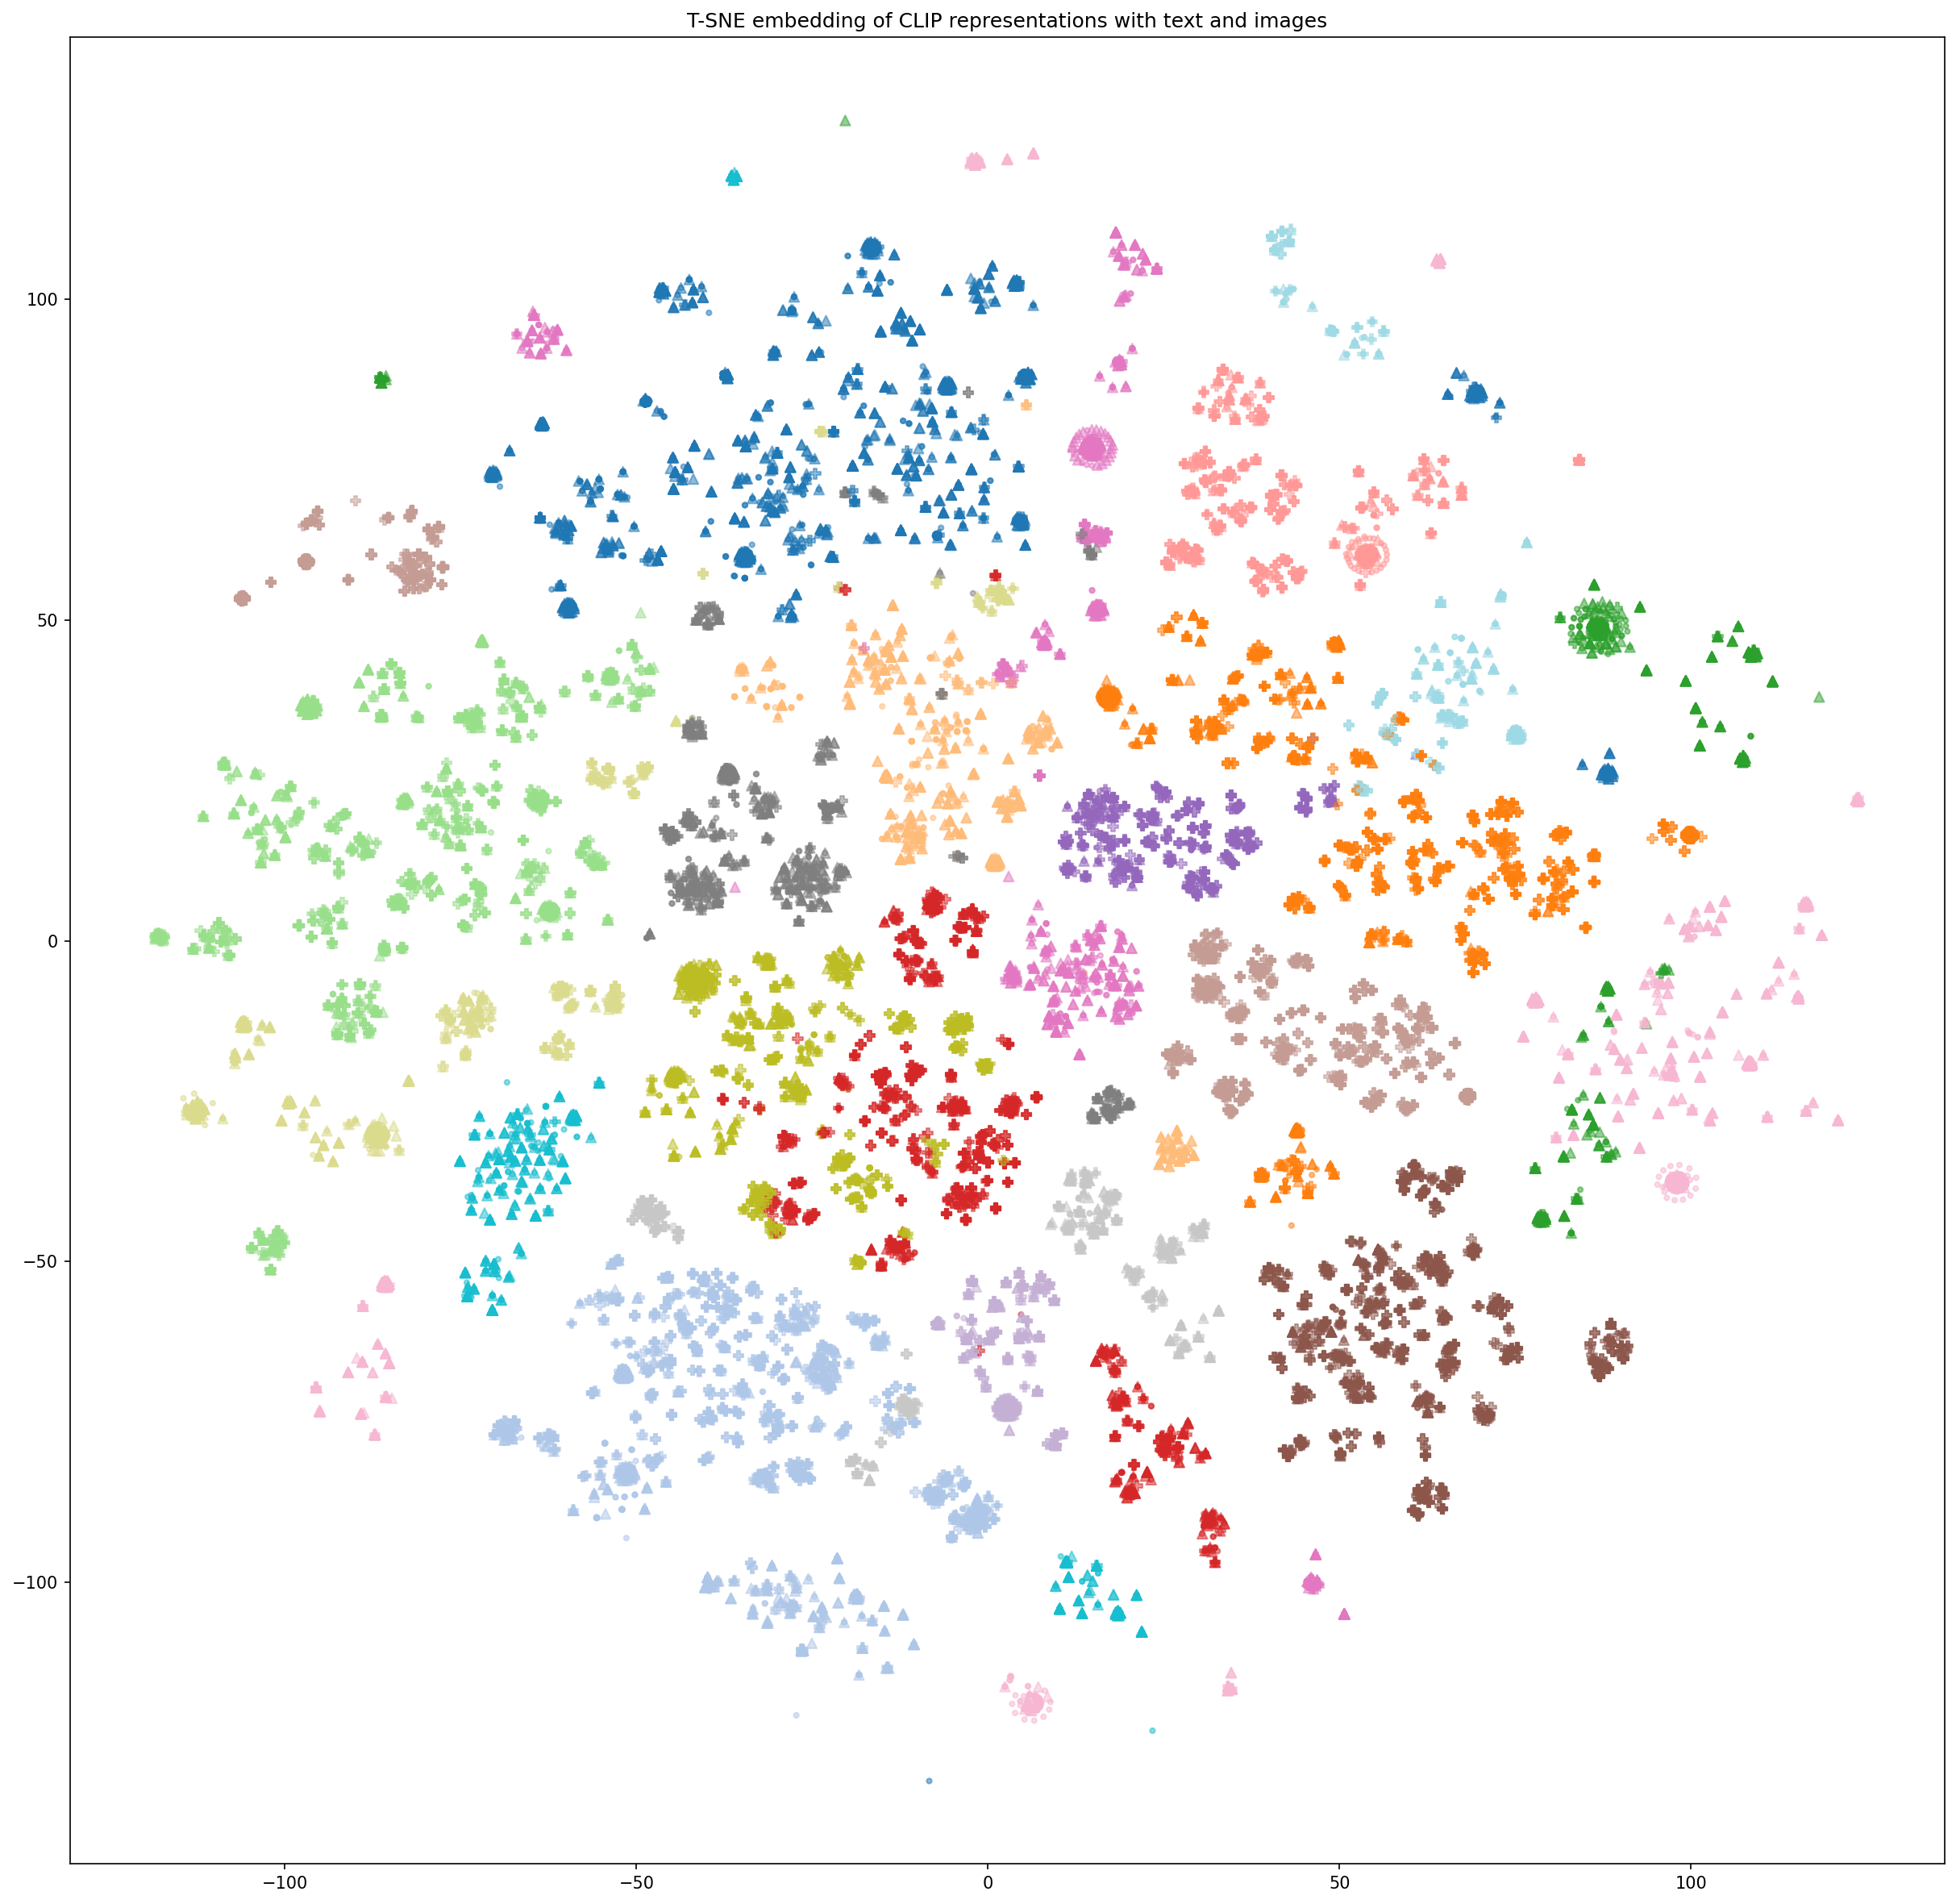

In [159]:
fig = plt.figure(figsize=(20,20), dpi=150)

netto_slice_start, netto_slice_end = label_slices[0]
plt.scatter(embedded_classes[netto_slice_start:netto_slice_end,0], embedded_classes[netto_slice_start:netto_slice_end,1], c=class_colors[netto_slice_start:netto_slice_end], alpha=.5, marker='.')
complement_start, complement_end = label_slices[1]
plt.scatter(embedded_classes[complement_start:complement_end,0], embedded_classes[complement_start:complement_end,1], c=class_colors[complement_start:complement_end], alpha=.5, marker='^')
random_start, random_end = label_slices[2]
plt.scatter(embedded_classes[random_start:random_end,0], embedded_classes[random_start:random_end,1], c=class_colors[random_start:random_end], alpha=.5, marker='P')
#plt.legend(handles=colors)
plt.title("T-SNE embedding of CLIP representations with text and images")